# Malaria Diagnosis With CNN

In [19]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import InputLayer,Conv2D, MaxPool2D, Dense, Flatten,BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, CSVLogger,LearningRateScheduler,ModelCheckpoint

In [2]:
from tensorflow.keras.metrics import BinaryAccuracy,FalsePositives,FalseNegatives,TruePositives,TrueNegatives,Precision,Recall,AUC

# Loading The Dataset

In [3]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True,shuffle_files=True,split=['train'])


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompletePJ9I2D/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [4]:
for data in dataset[0].take(1):
  print(data)
  break

(<tf.Tensor: shape=(103, 103, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)


In [5]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
  return train_dataset, val_dataset, test_dataset

# Data Visualization

In [6]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO )
print(list(train_dataset.take(1).as_numpy_iterator()),
      list(val_dataset.take(1).as_numpy_iterator()), list(test_dataset.take(1).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 0)] [(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
     

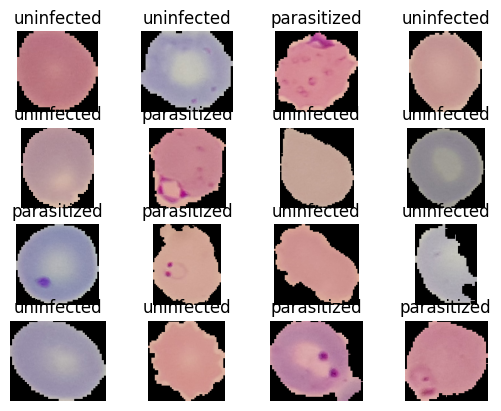

In [ ]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

# Data Preprocessing

In [ ]:
dataset_info.features['label'].int2str(0)

'parasitized'

In [7]:
IM_SIZE=224
def resize_rescale(image, label):

  return tf.image.resize(image, (IM_SIZE,IM_SIZE))/255, label

In [8]:
train_dataset=train_dataset.map(resize_rescale)
val_dataset=val_dataset.map(resize_rescale)
test_dataset=test_dataset.map(resize_rescale)



In [9]:
for image,label in train_dataset.take(1):
  print(image,label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


In [10]:
train_dataset = train_dataset.shuffle(buffer_size=8,reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [11]:
val_dataset = val_dataset.shuffle(buffer_size=8,reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)


In [12]:
test_dataset = test_dataset.shuffle(buffer_size=8,reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)


# Model Creation

In [15]:
lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters=6,kernel_size=3, strides=1, padding='valid',
          activation = 'relu'),
    BatchNormalization(),
    MaxPool2D (pool_size=2, strides=2),


    Conv2D(filters=16, kernel_size=3, strides=1, padding='valid',
          activation = 'relu'),
    BatchNormalization(),
    MaxPool2D (pool_size=2, strides=2),

    Flatten(),

    Dense(128, activation="relu"),
    BatchNormalization(),

    Dense( 10, activation="relu"),

    Dense(1, activation = "sigmoid"),

])

lenet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_3 (Bat  (None, 222, 222, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_4 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                      

In [ ]:
y_true = [0, 1, 0, 0]
y_pred = [0.6, 0.51, 0.94, 1]
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
bce(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=1.0227046>

In [18]:
metrics = [BinaryAccuracy(name='accuracy'),FalsePositives(name='fp'),FalseNegatives(name='fn'),TruePositives(name='tp'),TrueNegatives(name='tn'),Precision(name='precision'),Recall(name='recall'),AUC(name='auc')]

In [17]:

lenet_model.compile(optimizer=Adam(learning_rate=0.01),
                    loss=BinaryCrossentropy(),
                    metrics=metrics)

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

# Model Visualization

<Axes: >

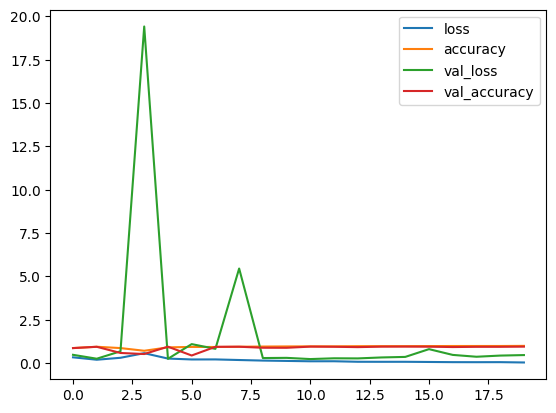

In [ ]:
import pandas as pd
losses = pd.DataFrame(history.history)
losses.plot()

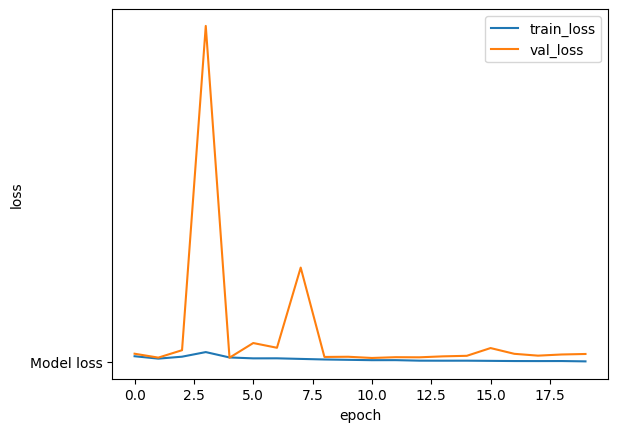

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'])
plt.show()

# Saving and Loading Model

In [ ]:
from tensorflow.keras.models import load_model
lenet_model.save('malaria')

In [ ]:
loaded_model = load_model('malaria')
loaded_model.evaluate(test_dataset)

87/87 [==============================] - 13s 45ms/step - loss: 0.5007 - accuracy: 0.9369


[0.5007435083389282, 0.9368879199028015]

In [ ]:
test_dataset = test_dataset.batch(1)

In [ ]:
test_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

# Model Evaluation

In [ ]:
#lenet_model.evaluate(test_dataset)

In [ ]:
def parasite_or_not(x):
  if (x<0.5):
    return str('P')
  else:
    return str('U')

In [ ]:
parasite_or_not(lenet_model.predict(test_dataset.take(1))[0][0])

1/1 [==============================] - 11s 11s/step


'P'

1/1 [==============================] - 0s 26ms/step


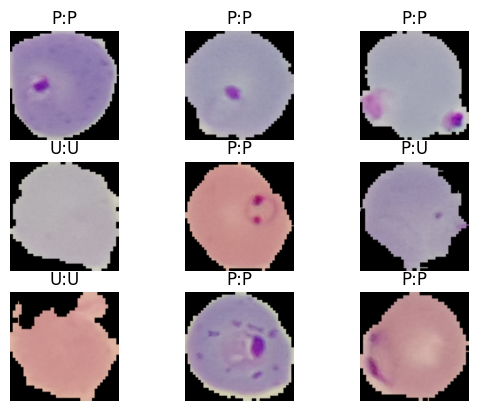

In [ ]:
for i, (image, label) in enumerate(test_dataset.take(9)):
  ax = plt.subplot(3,3, i+1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0])) + ":"+ str(parasite_or_not(lenet_model.predict(image)[0][0])))

  plt.axis('off')

In [ ]:
!!cp -r "/content/malaria" "/content/drive/My Drive/"


[]

In [ ]:
lenet_model.evaluate(test_dataset)

87/87 [==============================] - 16s 40ms/step - loss: 0.5412 - accuracy: 0.5125 - fp: 6.0000 - fn: 1338.0000 - tp: 27.0000 - tn: 1386.0000 - precision: 0.8182 - recall: 0.0198 - auc: 0.9648


[0.5412297248840332,
 0.5125135779380798,
 6.0,
 1338.0,
 27.0,
 1386.0,
 0.8181818127632141,
 0.019780220463871956,
 0.9647789597511292]

# Model Checkpoints

In [21]:
checkpoint_callback = ModelCheckpoint(
    'checkpoints/',
    monitor = 'val_loss',
    verbose = 0,
    save_best_only = True,
    save_weights_only = False,
    mode = 'auto',
    save_freq='epoch'
)

**The model training checkpoints are saved in assets folder**

In [22]:
history=lenet_model.fit(train_dataset,validation_data=val_dataset,epochs=10,verbose=1,callbacks=[checkpoint_callback])

Epoch 1/10
689/689 [==============================] - 67s 74ms/step - loss: 0.2824 - accuracy: 0.8934 - fp: 1467.0000 - fn: 884.0000 - tp: 10139.0000 - tn: 9556.0000 - precision: 0.8736 - recall: 0.9198 - auc: 0.9490 - val_loss: 0.2429 - val_accuracy: 0.9419 - val_fp: 101.0000 - val_fn: 59.0000 - val_tp: 1332.0000 - val_tn: 1263.0000 - val_precision: 0.9295 - val_recall: 0.9576 - val_auc: 0.9755
Epoch 2/10
689/689 [==============================] - 52s 76ms/step - loss: 0.2566 - accuracy: 0.9049 - fp: 1254.0000 - fn: 843.0000 - tp: 10178.0000 - tn: 9771.0000 - precision: 0.8903 - recall: 0.9235 - auc: 0.9582 - val_loss: 0.3507 - val_accuracy: 0.8853 - val_fp: 292.0000 - val_fn: 24.0000 - val_tp: 1368.0000 - val_tn: 1071.0000 - val_precision: 0.8241 - val_recall: 0.9828 - val_auc: 0.9658
Epoch 3/10
689/689 [==============================] - 53s 77ms/step - loss: 0.1956 - accuracy: 0.9316 - fp: 975.0000 - fn: 532.0000 - tp: 10491.0000 - tn: 10048.0000 - precision: 0.9150 - recall: 0.9517